### Testing PAR-2 alleles with a combination of point mutations in the RING domain

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

from src import (
    add_stats_table_row,
    bootstrap_effect_size_pd,
    bounded_mean_1d,
    dataplot,
    load_image,
    nb_setup,
    raw_data_path,
    rotated_embryo,
)

nb_setup()
os.makedirs("Figs", exist_ok=True)

%matplotlib inline

### Quantification

In [2]:
# Import data
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")

# Filter relevant data
lines = ["lp637", "nwg240", "nwg338", "nwg400", "nwg407", "nwg351"]
df = df[df.Line.isin(lines) & (df.RNAi == "wt")]
df_quantification = df_quantification[df_quantification.EmbryoID.isin(df.EmbryoID)]


# Perform summary quantification
def calculate_summary(group):
    cyt = group["Cytoplasmic signal"].mean()
    mem_tot = group["Membrane signal"].mean()
    mem_ant = bounded_mean_1d(group["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(group["Membrane signal"], [0.9, 0.1])
    ratio_post = mem_post / cyt
    return pd.Series(
        {
            "Cyt": cyt,
            "Mem_tot": mem_tot,
            "Mem_ant": mem_ant,
            "Mem_post": mem_post,
            "Ratio post": ratio_post,
        }
    )


df_summary = (
    df_quantification.groupby("EmbryoID").apply(calculate_summary).reset_index()
)
df = pd.merge(df, df_summary, on="EmbryoID")

# Add genotype column
genotype_dict = {
    "lp637": "WT",
    "nwg240": "C56S",
    "nwg338": "L109R",
    "nwg400": "L50R",
    "nwg407": "C56S+L109R",
    "nwg351": "L50R+L109R",
}
df["Genotype"] = df["Line"].map(genotype_dict)

### Figure

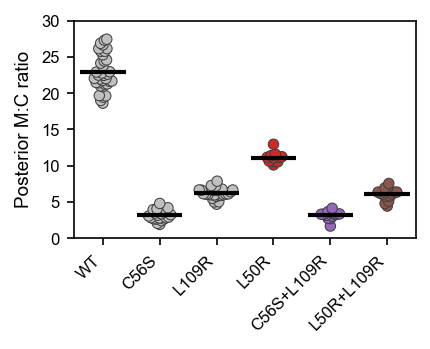

In [3]:
# Set up figure
fig, ax = plt.subplots(figsize=(15, 2.5))
offset = lambda p: transforms.ScaledTranslation(p / 72.0, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# Color pallete
order = ["WT", "C56S", "L109R", "L50R", "C56S+L109R", "L50R+L109R"]
colors = ["silver", "silver", "silver", "tab:red", "tab:purple", "tab:brown"]

# Plot data
dataplot(
    data=df,
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    linewidth=0.5,
    palette=colors,
    width=0.8,
    linewidth_mean=2,
    transform=trans + offset(0),
)

# Finalise figure
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")

ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("")
ax.set_ylim(0, 30)
ax.set_ylabel("Posterior M:C ratio", fontsize=9)
fig.set_size_inches(3.5, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.3)
fig.savefig("Figs/mcr.png", dpi=600, transparent=True)
fig.savefig("Figs/mcr.pdf", transparent=True)

In [4]:
# Effect size L50R vs WT
es, pr, ss = bootstrap_effect_size_pd(
    data=df, x="Genotype", y="Ratio post", a="WT", b="L50R"
)
add_stats_table_row(
    figure="S1",
    panel="D",
    sample_a="PAR-2(WT)",
    sample_b="PAR-2(L50R)",
    measure="Posterior M:C ratio (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="AdvyF5RinK",
)

# Effect size C56S+L109R vs C56S
es, pr, ss = bootstrap_effect_size_pd(
    data=df, x="Genotype", y="Ratio post", a="C56S", b="C56S+L109R"
)
add_stats_table_row(
    figure="S1",
    panel="D",
    sample_a="PAR-2(C56S)",
    sample_b="PAR-2(C56S,L109R)",
    measure="Posterior M:C ratio (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="wQhVJSlKeD",
)

# Effect size L50R+L109R vs L109R
es, pr, ss = bootstrap_effect_size_pd(
    data=df, x="Genotype", y="Ratio post", a="L109R", b="L50R+L109R"
)
add_stats_table_row(
    figure="S1",
    panel="D",
    sample_a="PAR-2(L109R)",
    sample_b="PAR-2(L50R,L109R)",
    measure="Posterior M:C ratio (mean)",
    effect_size=es,
    probability_distribution=pr,
    sample_size=ss,
    key="j4t0Gvbi0v",
)

### Images

In [5]:
def panel(path, ax, scale_bar=False):
    img = load_image(path + "/af_corrected.tif")
    roi = np.loadtxt(path + "/ROI_fit.txt")
    rotated = rotated_embryo(img, roi, 220, 160, 3)
    print(np.percentile(rotated, 99.9))
    ax.imshow(rotated, cmap="gray", vmin=0, vmax=34004.34257313967)
    ax.set_xticks([])
    ax.set_yticks([])

    if scale_bar:
        px = 0.255  # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated.shape[0] - 10
        ax.plot(
            [rotated.shape[1] - 10 - bar_pixels, rotated.shape[1] - 10],
            [y, y],
            color="w",
            linewidth=2,
        )

34239.15804478359
9841.27205465237
14053.559445605026
15394.23009761035


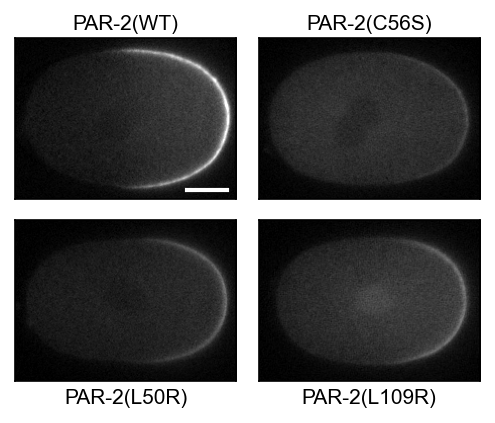

In [6]:
if raw_data_path:
    WT_path = raw_data_path + df[df["Genotype"] == "WT"].iloc[1]["Path"]
    C56S_path = raw_data_path + df[df["Genotype"] == "C56S"].iloc[1]["Path"]
    L50R_path = raw_data_path + df[df["Genotype"] == "L50R"].iloc[0]["Path"]
    L109R_path = raw_data_path + df[df["Genotype"] == "L109R"].iloc[0]["Path"]

    fig, ax = plt.subplots(2, 2)
    panel(WT_path, ax[0][0], scale_bar=True)
    panel(C56S_path, ax[0][1])
    panel(L50R_path, ax[1][0])
    panel(L109R_path, ax[1][1])

    ax[0][0].set_xlabel("PAR-2(WT)", fontsize=10)
    ax[0][0].xaxis.set_label_position("top")
    ax[0][1].set_xlabel("PAR-2(C56S)", fontsize=10)
    ax[0][1].xaxis.set_label_position("top")
    ax[1][0].set_xlabel("PAR-2(L50R)", fontsize=10)
    ax[1][1].set_xlabel("PAR-2(L109R)", fontsize=10)

    fig.set_size_inches(4, 3)
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.savefig("Figs/l50r_l109r.png", dpi=600, transparent=True)
    fig.savefig("Figs/l50r_l109r.pdf", transparent=True)